# Time Series Analysis II

*N. Hernitschek, 2022*

This is the nineth Jupyter notebook for **ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)**. 
This Jupyter notebook gives a more detailed introduction to time series analysis for astronomical data.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray

***Exercises required for class participation are in <font color='red'>red</font>.***


---
## Contents
* [Autoregressive Models](#first-bullet)
* [Correlation Functions](#second-bullet)

## 1. Autoregressive Models <a class="anchor" id="first-bullet"></a>

In an $MA$ process a "shock/impulse" affects only the current value and $q$ values into the future.  In an $AR$ process a "shock/impulse" affects *all* future values. 

We can also ***combine AR(p) and MA(q) processes into ARMA(p,q)*** to characterize more complicated data. For example an ARMA(2,1) model combines AR(2) and MA(1):

$$y_i = a_1y_{i-1} +  a_2y_{i-2} + \epsilon_i + b_1 \epsilon_{i-1}.$$

Below is some code and a plot that illustrates this. <font color='red'>Try changing the coefficients (in the yAR, yMA, and yARMA equations) and see what happens.  (You may need to change the plot limits depending on your choices.)</font>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

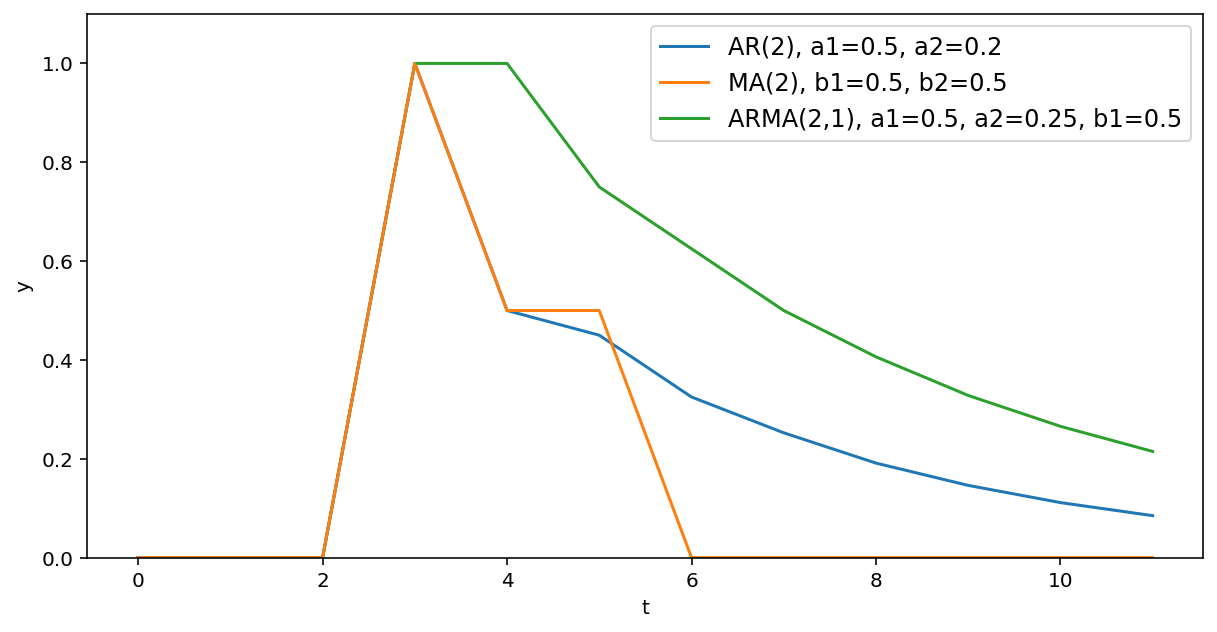

In [2]:
from matplotlib.ticker import MultipleLocator

N = 10

#epsilon = np.array([0,0,0,1,0,0,
#                    0,0,0,0,0,0])
epsilon = np.zeros(N+2)
epsilon[3] = 1

yAR = np.zeros(N+2)
yMA = np.zeros(N+2)
yARMA = np.zeros(N+2)

for i in np.arange(N)+2:
    # Complete
    yAR[i] = 0.5*yAR[i-1] + 0.2*yAR[i-2] + epsilon[i]
    yMA[i] = epsilon[i] + 0.5*epsilon[i-1] + 0.5*epsilon[i-2]
    yARMA[i] = 0.25*yARMA[i-2] + 0.5*yARMA[i-1] + epsilon[i] + 0.5*epsilon[i-1] 
    #print i, yAR[i], yMA[i]

###
fig = plt.figure(figsize=(10, 5))

t = np.arange(len(yAR))
plt.plot(t,yAR,label="AR(2), a1=0.5, a2=0.2")
plt.plot(t,yMA,label="MA(2), b1=0.5, b2=0.5")
plt.plot(t,yARMA,label="ARMA(2,1), a1=0.5, a2=0.25, b1=0.5",zorder=0)

plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="upper right",
           prop={'size':12})
plt.ylim([0,1.1])

plt.show()

## 2. Correlation Functions <a class="anchor" id="first-bullet"></a>


astroML has tools for **computing the ACF of *unevenly sampled* data** using two different methods: 
1. [Scargle method](https://ui.adsabs.harvard.edu/abs/1989ApJ...343..874S/abstract)
2. [Edelson & Krolik method](https://ui.adsabs.harvard.edu/abs/1988ESASP.281b.387E/abstract)

[http://www.astroml.org/modules/classes.html#module-astroML.time_series](http://www.astroml.org/modules/classes.html#module-astroML.time_series)

One of the tools is for generating a **damped random walk (DRW)**, which we recall is a process that "remembers" its history only for a characteristic time, $\tau$. The ACF vanishes for $\Delta t \gg \tau$.

*Warning below may require changing to astropy's LS periodogram function.*

In [3]:
# Syntax for EK and Scargle ACF computation
from astroML.time_series import generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

t = np.arange(0,1000)
y = generate_damped_RW(t, tau=300)
dy = 0.1
y = np.random.normal(y,dy)

ACF_scargle, bins_scargle = ACF_scargle(t,y,dy)
ACF_EK, ACF_err_EK, bins_EK = ACF_EK(t,y,dy)

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


<font color='red'>Figure 10.30 from the textbook gives an example of an ACF for a DRW, which mimics the variability that we might see from a *quasar whose lightcurve is unevenly sampled*.</font>

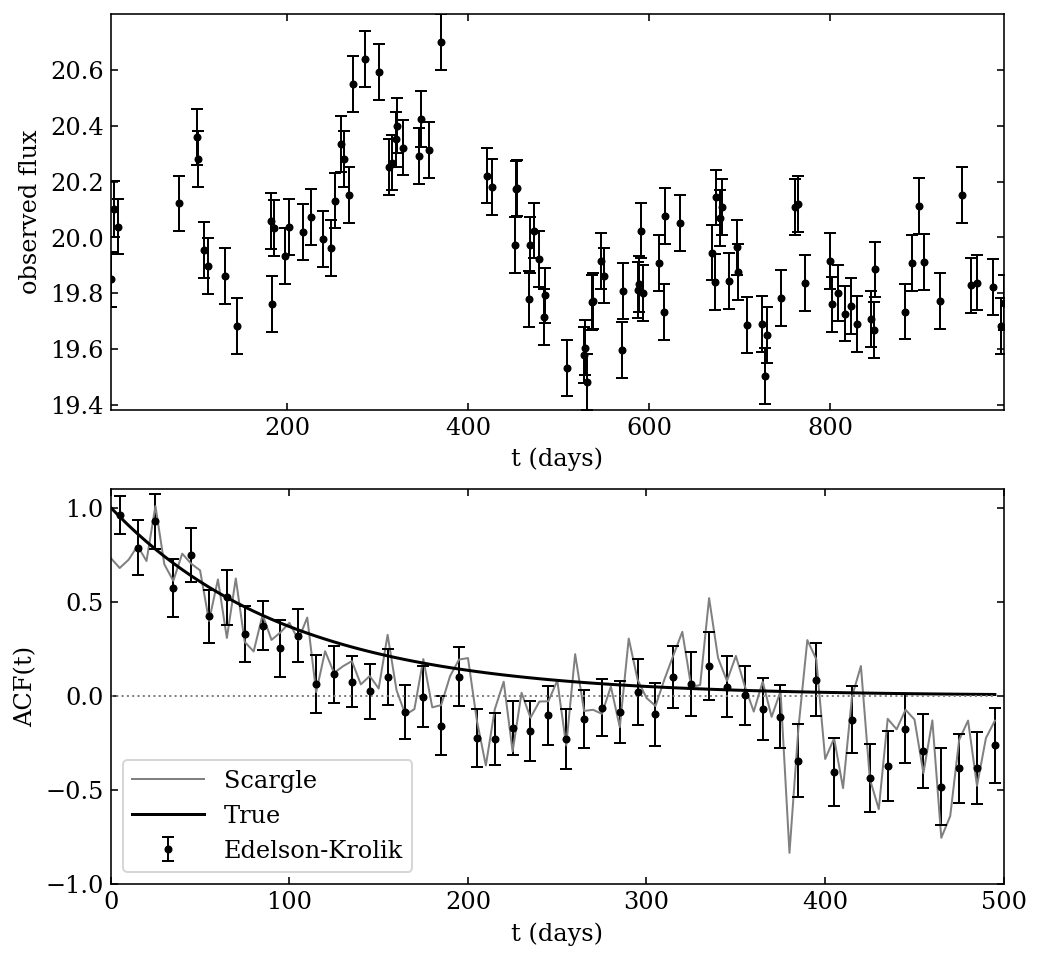

In [4]:
# Ivezic v2, Figure 10.30
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Generate time-series data:
#  we'll do 1000 days worth of magnitudes

t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, 
                       z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# compute ACF via scargle method
C_S, t_S = ACF_scargle(t, y_obs, dy,
                       n_omega=2. ** 12, 
                       omega_max=np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

#------------------------------------------------------------
# compute ACF via E-K method
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, 
                              bins=np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 8))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1,
        label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1,
            label='Edelson-Krolik')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

plt.show()

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* an good of time series in astronomy
* seen many algorithms that enable you to extract various information from realistic astronomical time series.